In [1]:
import torch

print('pytorch version:', torch.__version__)
print('cuda version needed:', torch.version.cuda)
print('cudnn version:', torch.backends.cudnn.version())

pytorch version: 1.5.0
cuda version needed: 10.2
cudnn version: 7605


In [2]:
!nvcc -V
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89
Wed Jun  3 12:20:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 60%   76C    P2   134W / 250W |   5607MiB / 11178MiB |     69%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 

In [2]:
import json
import numpy as np
from deps import *
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print('ok')

device = 'cuda'
use_dcn = False
figure_path = './figures-pytorch1.1.0-cuda9.0'

ok


In [3]:
T = 10
C = 64
sizes = [[100,100], [50,50], [25, 25], [13,13], [7,7]]
shapes = [[2,C,s[0],s[1]] for s in sizes]

mb = MontageBlock('type-2', False, device=device)
Xs = gen_problem(shapes, device)
Xs_ext = Xs + Xs[-3:]
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    ret = mb(Xs_ext)
print(prof)
print(ret.shape)

-----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                     Self CPU total %   Self CPU total      CPU total %        CPU total     CPU time avg     CUDA total %       CUDA total    CUDA time avg  Number of Calls
-----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
to                                 0.24%          6.986us            0.24%          6.986us          6.986us            0.18%          5.120us          5.120us                1
detach_                            0.14%          4.158us            0.14%          4.158us          4.158us            0.14%          4.096us          4.096us                1
to                                 1.85%         53.006us            1.85%         53.006us         53.006us      

4 6.793659973144531 4.540040588378906 7.77912343343099 8.247807820638021
5 7.3163091023763025 5.724296569824219 12.15853271484375 12.086679077148437
6 8.828143310546874 6.841719563802084 13.746347045898437 11.849489339192708
7 9.958502197265625 7.994333902994792 15.740181477864583 19.161258951822916
8 11.078006998697917 9.122611490885417 15.305731201171875 20.79600626627604
9 12.252569580078125 10.26519063313802 17.35813191731771 18.130668131510415
10 13.043814086914063 11.437977091471355 19.343499755859376 20.176277669270835
11 14.484889729817708 12.645375569661459 21.252608235677084 21.769114176432293
12 15.368055216471355 13.784269205729167 23.38150634765625 23.86448974609375
13 16.514389038085938 14.95531514485677 25.04775594075521 25.770017496744792
14 18.00362752278646 16.169744873046874 26.962740071614583 29.84915568033854
15 19.004996744791665 17.308331298828126 28.611344401041666 28.947519938151043
16 20.16208292643229 18.452992757161457 30.82386678059896 31.721539306640626
17

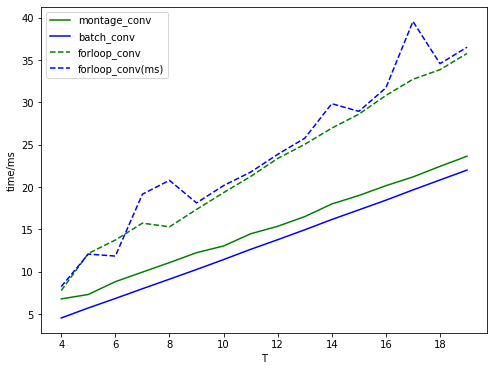

In [5]:
# time with increasing T
C = 128
sizes = [[100,100], [50, 50], [25,25], [13,13], [7,7]]
shapes = [[2,C,s[0],s[1]] for s in sizes]

mb = MontageBlock('type-1', True, device=device)
Xs = gen_problem(shapes, device)
Xs_ext = Xs + Xs[-3:]
X = mb(Xs_ext)

Ts = np.arange(4, 20, 1)
n_repeat = 30
times1, times2, times3, times4 = [], [], [], []
for T in Ts:
    
    mcs_enable = MontageConvSeq(C, T, 3, enable_montage=True, use_dcn=use_dcn)
    mcs_disable = MontageConvSeq(C, T, 3, enable_montage=False, use_dcn=use_dcn)
    scs_ss = SeparateConvSeq(C, T, 3, False, use_dcn=use_dcn)
    scs_ms = SeparateConvSeq(C, T, 3, True, use_dcn=use_dcn)
    mcs_enable.to(device)
    mcs_disable.to(device)
    scs_ss.to(device)
    scs_ms.to(device)
    
    t1 = timing(mcs_enable, [Xs_ext], n_repeat)
    t2 = timing(mcs_disable, [X], n_repeat)
    t3 = timing(scs_ss, [Xs_ext], n_repeat)
    t4 = timing(scs_ms, [Xs_ext], n_repeat)
    times1.append(t1)
    times2.append(t2)
    times3.append(t3)
    times4.append(t4)
    print(T, t1, t2, t3, t4)

times1 = np.array(times1)
times2 = np.array(times2)
times3 = np.array(times3)
times4 = np.array(times4)
plt.figure(figsize=(8,6))
plt.plot(Ts, times1, 'g')
plt.plot(Ts, times2, 'b')
plt.plot(Ts, times3, 'g--')
plt.plot(Ts, times4, 'b--')
plt.xlabel('T')
plt.ylabel('time/ms')
plt.legend(['montage_conv','batch_conv','forloop_conv', 'forloop_conv(ms)'])
plt.savefig(figure_path+'/torch_GPU_C128_incT.png')

data = dict(
    Ts=list(Ts.astype(float)),
    montage_conv=list(times1),
    batch_conv=list(times2),
    forloop_conv=list(times3),
    forloop_conv_ms=list(times4),
)
with open(figure_path+'/torch_GPU_C128_incT.json', 'w') as f:
    json.dump(data, f)

32 5.223355611165364 2.992638905843099 19.419340006510417 19.440128580729166
64 7.051571146647135 4.760166422526042 19.282466634114584 19.734733072916665
128 12.81624755859375 11.217476399739583 19.324961344401043 19.59437459309896
256 33.207568359375 31.70689697265625 38.45700276692708 36.43016357421875
512 107.08487141927084 105.6332763671875 114.83603515625 117.49014485677084


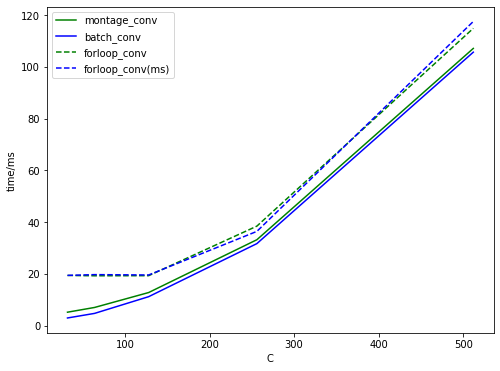

In [6]:
# timing with increasing C

mb = MontageBlock('type-1', True, device=device)

T = 10
Cs = [32, 64, 128, 256, 512]
sizes = [[100,100], [50,50], [25, 25], [13,13], [7,7]]
n_repeat = 30
times1, times2, times3, times4 = [], [], [], []
for C in Cs:
    shapes = [[2,C,s[0],s[1]] for s in sizes]
    Xs = gen_problem(shapes, device)
    Xs_ext = Xs + Xs[-3:]
    X = mb(Xs_ext)
    
    mcs_enable = MontageConvSeq(C, T, 3, enable_montage=True, use_dcn=use_dcn)
    mcs_disable = MontageConvSeq(C, T, 3, enable_montage=False, use_dcn=use_dcn)
    scs_ss = SeparateConvSeq(C, T, 3, False, use_dcn=use_dcn)
    scs_ms = SeparateConvSeq(C, T, 3, True, use_dcn=use_dcn)
    mcs_enable.to(device)
    mcs_disable.to(device)
    scs_ss.to(device)
    scs_ms.to(device)
    
    t1 = timing(mcs_enable, [Xs_ext], n_repeat)
    t2 = timing(mcs_disable, [X], n_repeat)
    t3 = timing(scs_ss, [Xs_ext], n_repeat)
    t4 = timing(scs_ms, [Xs_ext], n_repeat)
    times1.append(t1)
    times2.append(t2)
    times3.append(t3)
    times4.append(t4)

    print(C, t1, t2, t3, t4)
    
times1 = np.array(times1)
times2 = np.array(times2)
times3 = np.array(times3)
times4 = np.array(times4)
plt.figure(figsize=(8,6))
plt.plot(Cs, times1, 'g')
plt.plot(Cs, times2, 'b')
plt.plot(Cs, times3, 'g--')
plt.plot(Cs, times4, 'b--')
plt.xlabel('C')
plt.ylabel('time/ms')
plt.legend(['montage_conv','batch_conv','forloop_conv','forloop_conv(ms)'])
plt.savefig(figure_path+'/torch_GPU_T10_incC.png')

data = dict(
    Cs=Cs,
    montage_conv=list(times1),
    batch_conv=list(times2),
    forloop_conv=list(times3),
    forloop_conv_ms=list(times4),
)
with open(figure_path+'/torch_GPU_T10_incC.json', 'w') as f:
    json.dump(data, f)

2.0 43.91407063802083 42.11005452473958 43.116748046875 42.452311197916664
1.8 36.6916259765625 35.05701497395833 35.72630208333333 35.00861409505208
1.6 28.0560302734375 26.445550537109376 27.79074503580729 27.201298014322916
1.4 22.692010498046876 21.08719685872396 23.064131673177084 22.760003662109376
1.2 17.175791422526043 15.643267822265624 19.361075846354165 20.454878743489584
1.0 12.956228637695313 11.472589111328125 19.242291259765626 19.546590169270832
0.8 8.837188720703125 6.889608764648438 18.81961873372396 19.14894002278646
0.6 5.784132385253907 4.327048746744792 19.01827392578125 19.026192220052085
0.4 4.196693420410156 2.367249043782552 19.05103963216146 19.07241007486979


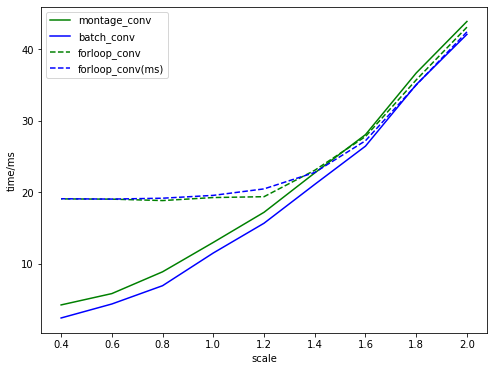

In [7]:
# increasing image size

mb = MontageBlock('type-1', True, device=device)
base_sizes = [[100,100], [50,50], [25, 25], [13,13], [7,7]]

def resize(base_sizes, scale):
    sizes = []
    for i, (a, b) in enumerate(base_sizes):
        sizes.append([int(a*scale), int(b*scale)])
    return sizes

T = 10
C = 128
scales = [2.0,1.8,1.6,1.4,1.2,1.0,0.8,0.6,0.4]
n_repeat = 30
times1, times2, times3, times4 = [], [], [], []
areas = []
for scale in scales:
    sizes = resize(base_sizes, scale)
    shapes = [[2,C,s[0],s[1]] for s in sizes]
    areas.append(sizes[0][0]*sizes[0][1])
    
    Xs = gen_problem(shapes, device)
    Xs_ext = Xs + Xs[-3:]
    X = mb(Xs_ext)

    mcs_enable = MontageConvSeq(C, T, 3, enable_montage=True, use_dcn=use_dcn)
    mcs_disable = MontageConvSeq(C, T, 3, enable_montage=False, use_dcn=use_dcn)
    scs_ss = SeparateConvSeq(C, T, 3, False, use_dcn=use_dcn)
    scs_ms = SeparateConvSeq(C, T, 3, True, use_dcn=use_dcn)
    mcs_enable.to(device)
    mcs_disable.to(device)
    scs_ss.to(device)
    scs_ms.to(device)
    
    t1 = timing(mcs_enable, [Xs_ext], n_repeat)
    t2 = timing(mcs_disable, [X], n_repeat)
    t3 = timing(scs_ss, [Xs_ext], n_repeat)
    t4 = timing(scs_ms, [Xs_ext], n_repeat)
    times1.append(t1)
    times2.append(t2)
    times3.append(t3)
    times4.append(t4)
    print(scale, t1, t2, t3, t4)

times1 = np.array(times1)
times2 = np.array(times2)
times3 = np.array(times3)
times4 = np.array(times4)
areas = np.array(areas)
plt.figure(figsize=(8,6))
plt.plot(scales, times1, 'g')
plt.plot(scales, times2, 'b')
plt.plot(scales, times3, 'g--')
plt.plot(scales, times4, 'b--')
plt.xlabel('scale')
plt.ylabel('time/ms')
plt.legend(['montage_conv','batch_conv','forloop_conv','forloop_conv(ms)'])
plt.savefig(figure_path+'/torch_GPU_T10_C128_incS.png')

data = dict(
    Ss=scales,
    montage_conv=list(times1),
    batch_conv=list(times2),
    forloop_conv=list(times3),
    forloop_conv_ms=list(times4),
)
with open(figure_path+'/torch_GPU_T10_C128_incS.json', 'w') as f:
    json.dump(data, f)
